In [32]:
import numpy as np
import pandas as pd
import h5py

The following code chunk loads in the .mat file storing the dataset. Usually .mat files can be loaded in using scipy but in our case, this newer version of .mat file requires h5py as it is stored in the HDF5 format. Using the h5py package which can load in HDF5 files, the .mat file can be loaded into python. The package h5py uses HDF5 object reference objects which are references in the original file that point to an array that is created when loaded into python (#refs#). To clean the file, they must be dereferenced so that the object reference can be replaced by the numpy array that it references. This process is only neccessary for arrays containing nested 2D arrays (ie 'trial' which is an array containing 276 14x1920 arrays). The following code loads in the EEG data, label data (valence and arousal), and the Hamilton Anxiety Rating Score (HAM). It dereferences the data, transposes it, and generates a subject id array that corresponds to the other arrays. It stores the arrays of data in a dictinoary (data_dict). 

In [33]:
# Load in matlab .mat EEG dataset with h5py package
DASPS = h5py.File('EEG Data/DASPS+HAM labels/DASPS+HAM labels.mat', 'r')

# Acess EEG neural recording trial data
trial_data = DASPS['Regim_datasub']['trial'][()]
trial_data = trial_data[0]
print(f"trial_data shape: {trial_data.shape}")  # Check shape
print(f"trial data[0]: {trial_data[0]}") # Check it is HDF5 object reference

# Access Labels (valence, arousal) for each trial
label_data = DASPS['Regim_datasub']['label'][()]
label_data = label_data[0]
print(f"label_data shape: {label_data.shape}")  # Check shape
print(f"label_data[0]: {label_data[0]}")  # Check it is an HDF5 object reference

# Access Hamilton Anxiety Rating Scores (HAM)
HAM = DASPS['Regim_datasub']['HAM'] 
HAM = np.array(HAM).T  # Convert to Numpy array and transpose
print(f"HAM shape: {HAM.shape}") # Check shape

# Function to dereference and extract EEG trial arrays
def access_reference(trial_ref):
    """Dereferences an HDF5 object reference and retrieves the corresponding EEG array."""

    ref_name = h5py.h5r.get_name(trial_ref, DASPS.id).decode('utf-8')  # Get reference name
    ref_key = ref_name.split('/')[-1]  # Extract the key name from the reference path
    trial_array = np.array(DASPS["#refs#"][ref_key])  # Retrieve and convert to NumPy array
    return trial_array 

# Create empty dictionary with preset dimensions
data_dict = {
    'trials': np.zeros((276, 1920, 14)),  # EEG data (14 channels, 1920 time points)
    'labels': np.zeros((276, 2)),  # Valence and Arousal (1x2)
    'HAM': np.zeros((276,)),  # Anxiety Rating (1D)
}

# Loop through all EEG trials and extract nested arrays from references
for i in range(len(trial_data)):
    ref = trial_data[i]  # Ensure you are getting the actual reference
    trial_array = access_reference(ref)  # Use reference to get array
    data_dict['trials'][i] = trial_array  # Store EEG data

# Loop through all Labels and extract nested arrays from references
for i in range(len(label_data)):
    ref = label_data[i]  # Ensure you are getting the actual reference
    label_array = access_reference(ref)  # Use reference to get array
    data_dict['labels'][i] = label_array.ravel()  # Store label data

# Add HAM 1D array to data dictionary
for i in range(len(HAM)):
    data_dict['HAM'][i] = HAM[i].item()

# Transpose all EEG data arrays and labels for ease 
data_dict['trials'] = [array.T for array in data_dict['trials']]
data_dict['labels'] = [array.T for array in data_dict['labels']]

# Add subject and scenario variables for clarity
subject_ids = [] #  Initialize the list to store subject IDs

# Add subject ID for each trial
for i in range(len(data_dict['trials'])):
    subject_id = (i // 12) + 1  # Every 12 trials, the subject changes
    subject_ids.append(subject_id)

# Convert subject_ids list to numpy array
subject_ids = np.array(subject_ids)

# Add the subject_ids to data_dict
data_dict['sub_ids'] = subject_ids


trial_data shape: (276,)
trial data[0]: <HDF5 object reference>
label_data shape: (276,)
label_data[0]: <HDF5 object reference>
HAM shape: (276, 1)


The following code chunk focuses on segmenting the cleaned EEG data into 1 second trials. This code followed an example preprocessing code in the EEG Conformer github but was written from scratch as the loading process with h5py was significantly different from scipy, which the EEG Conformer scripts uses. There are 12 trials per subject in the 'trials' array. For each subject, 6 different anxiety-inducing situations were administered verbally. The first 15 seconds of EEG data is the verbal adminsitration and the last 15 seconds of EEG data is the recall/visualization by the subject. As each of the 6 situations are divided into the two 15 second parts, this is how we get 12 trials per subject. Thus each trial represents 15 seconds and can be split into 15 seperate trials. This results in 4140 total trials across all 23 subjects. The labels and rating associated with each trials is saved in correpsonding arrays. 

In [34]:
# Segment each 15 second trial into 1 second trials

# Initialize lists
segmented_trials = []  # Store segmented EEG data
segmented_labels = []  # Store corresponding labels
segmented_HAM = []  # Store HAM ratings
segmented_sub_ids = []  # Store subject IDs for each 1-second segment

# Loop over all 276 trials
for trial_indx in range(len(data_dict['trials'])):  

    # Get data
    trial = data_dict['trials'][trial_indx]
    label = data_dict['labels'][trial_indx]  
    HAM = data_dict['HAM'][trial_indx] 
    sub_ids = data_dict['sub_ids'][trial_indx] 

    # Get number of 1-second segments (should always be 15)
    num_segments = trial.shape[1] // 128  # 1920 / 128 = 15

    # Loop through trials and segment into 128 long increments (1 second)
    for segment_indx in range(num_segments):
        segment_data = trial[ : , segment_indx * 128:(segment_indx + 1) * 128]  

        # Store segmented data
        segmented_trials.append(segment_data)
        segmented_labels.append(label)  # Store associated label
        segmented_HAM.append(HAM)  # Store associated HAM rating
        segmented_sub_ids.append(sub_ids) # Store associated subject


# Convert lists to NumPy arrays and check shape
segmented_trials = np.array(segmented_trials)  
print(segmented_trials.shape)
segmented_labels = np.array(segmented_labels)  
print(segmented_labels.shape)
segmented_HAM = np.array(segmented_HAM) 
print(segmented_HAM.shape)
segmented_sub_ids = np.array(segmented_sub_ids)  
print(segmented_sub_ids.shape)

# Store in data_dict
data_dict['segmented_trials'] = segmented_trials
data_dict['segmented_labels'] = segmented_labels
data_dict['segmented_HAM'] = segmented_HAM
data_dict['segmented_sub_ids'] = segmented_sub_ids



(4140, 14, 128)
(4140, 2)
(4140,)
(4140,)


The following code seperates the label data (valence and arousal) into four categories based on the published paper on the DASPS dataset. They defined anxiety as low valence, high arousal. The code impliments their description of how they categorized the anxiety states. 

In [35]:
# Categorization function
def categorize_anxiety(valence, arousal):
    """ Categorizes anxiety state in DASPS label data based on valence and arousal as described by Baghdadi et al. """

    if valence >= 0 and valence <= 2 and arousal >= 7 and arousal <= 9:
        return 'Severe Anxiety'
    elif valence >= 2 and valence <= 4 and arousal >= 6 and arousal <= 7:
        return 'Moderate Anxiety'
    elif valence >= 4 and valence <= 5 and arousal >= 5 and arousal <= 6:
        return 'Light Anxiety'
    else:
        return 'Normal Anxiety'

# Runs categorization for 267 15 seconds trials
anxiety_cat = []
for valence, arousal in data_dict['labels']:
    anxiety_cat.append(categorize_anxiety(valence, arousal))


print(f"Categories for 267 trials: {pd.DataFrame(anxiety_cat).value_counts()}")

# Runs categorization for 4140 1 second trials
anxiety_cat_segmented = []
for valence, arousal in data_dict['segmented_labels']:
    anxiety_cat_segmented.append(categorize_anxiety(valence, arousal))


print(f"\nCategories for 4140 trials: {pd.DataFrame(anxiety_cat_segmented).value_counts()}")

data_dict['anxiety_cat_segmented'] = anxiety_cat_segmented

# Convert to integer labels

# Define the mapping of string labels to integers
label_map = {
    "Normal Anxiety": 0,
    "Light Anxiety": 1,
    "Moderate Anxiety": 2,
    "Severe Anxiety": 3
}

# Convert string labels to integers using the mapping
anxiety_states = np.array([label_map[label] for label in anxiety_cat_segmented])

data_dict['anxiety_states'] = anxiety_states

print(f"\nCategories for Numeric Labels: {pd.DataFrame(anxiety_states).value_counts()}")

Categories for 267 trials: 0               
Normal Anxiety      134
Severe Anxiety       90
Light Anxiety        26
Moderate Anxiety     26
Name: count, dtype: int64

Categories for 4140 trials: 0               
Normal Anxiety      2010
Severe Anxiety      1350
Light Anxiety        390
Moderate Anxiety     390
Name: count, dtype: int64

Categories for Numeric Labels: 0
0    2010
3    1350
1     390
2     390
Name: count, dtype: int64


In [36]:
# Initialize a dictionary to hold the trials and labels for each subject
subject_dict = {}

# Loop through each subject ID
for sub_id in set(data_dict['segmented_sub_ids']):  # 'set' removes duplicates
    # Get the indices for this subject
    subject_indices = [i for i, x in enumerate(data_dict['segmented_sub_ids']) if x == sub_id]
    
    # Extract the trials and labels for this subject using the indices
    subject_trials = data_dict['segmented_trials'][subject_indices]  # shape (num_trials, 14, 128)
    subject_labels = [data_dict['anxiety_states'][i] for i in subject_indices]
    
    # Store the trials and labels in the dictionary
    subject_dict[sub_id] = {'trials': subject_trials, 'labels': subject_labels}


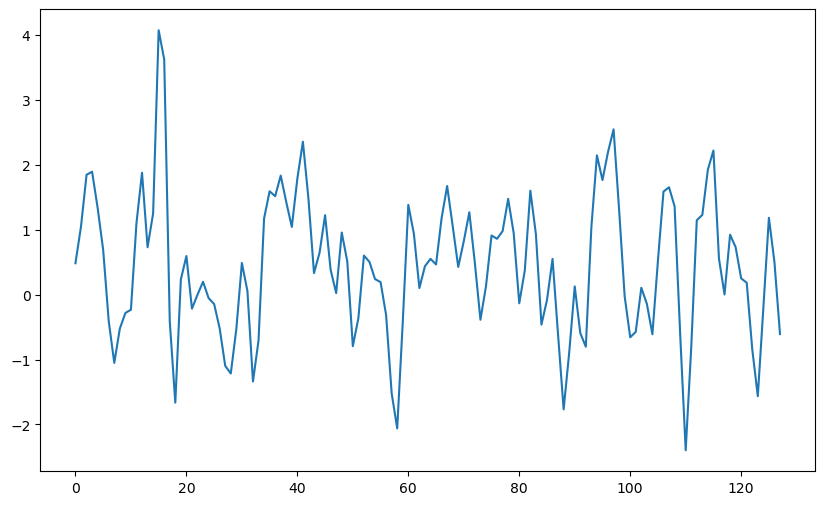

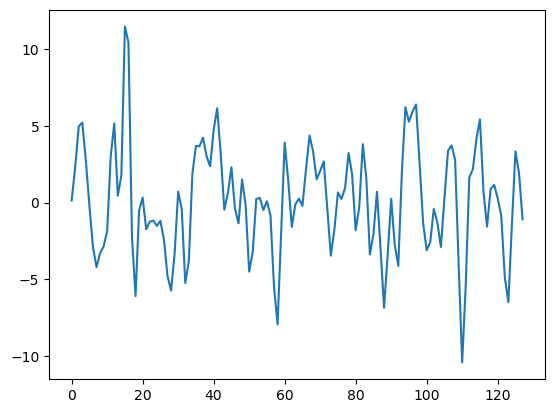

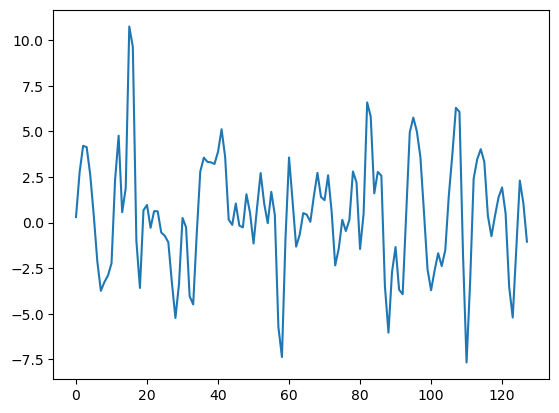

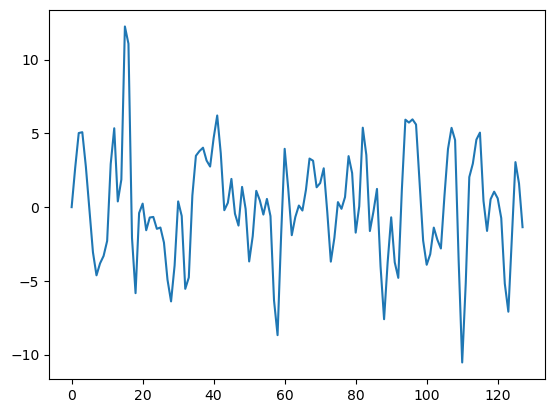

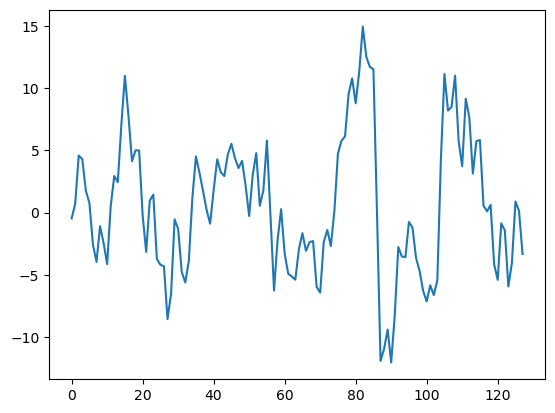

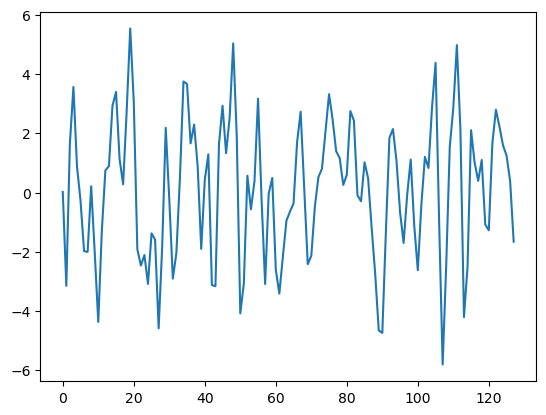

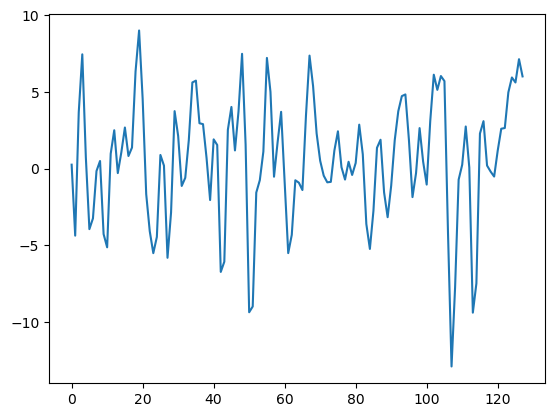

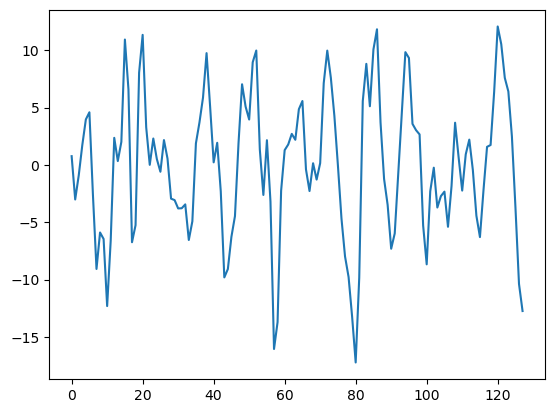

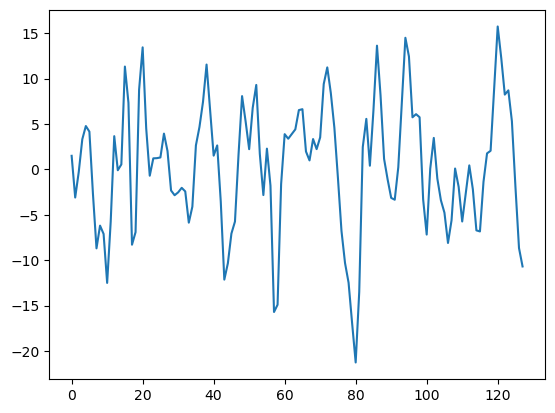

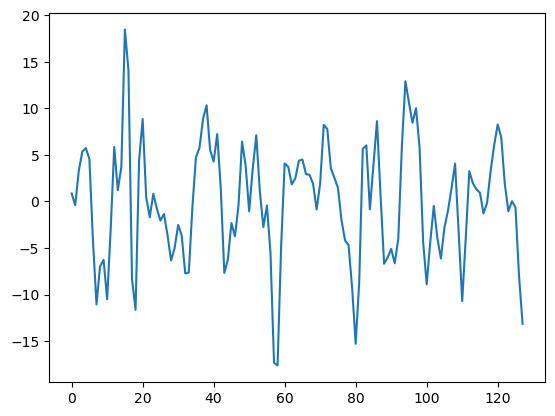

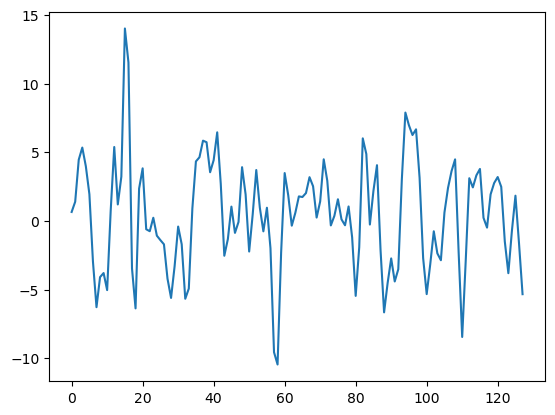

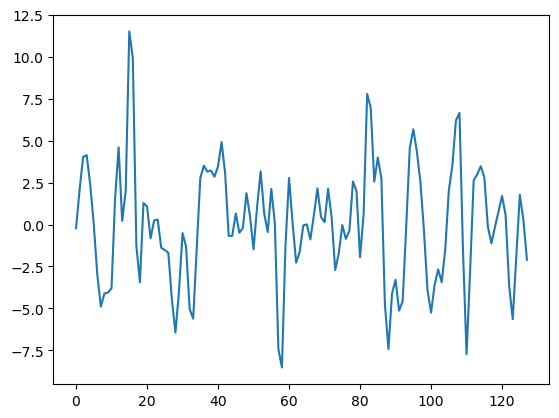

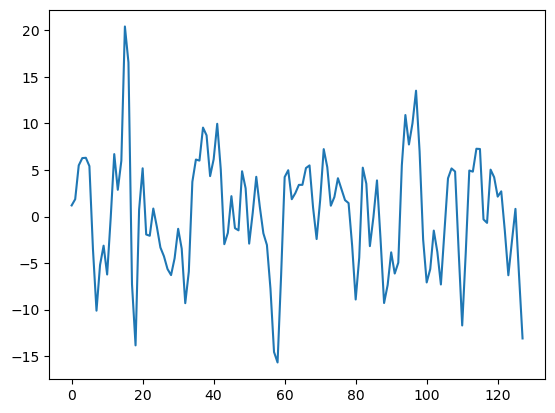

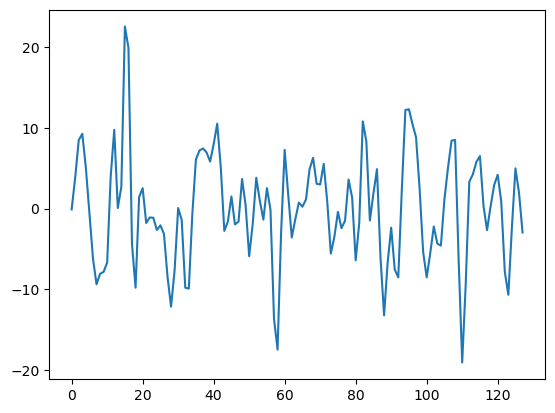

/var/folders/6h/gw1s_f8s3ts1m_tz3lgkbx480000gn/T/ipykernel_16787/1825419521.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


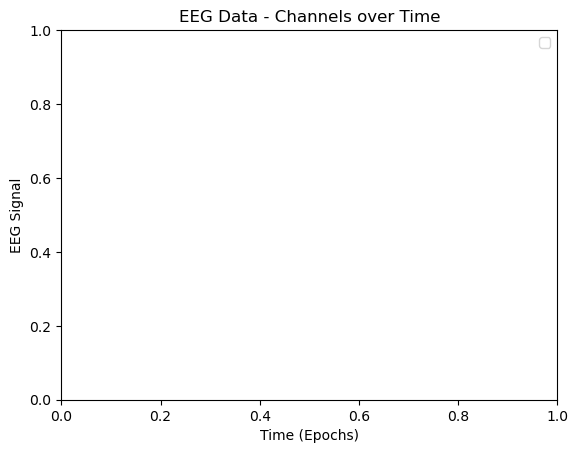

(128,)

In [96]:
import matplotlib.pyplot as plt
subject_dict[10]['trials']
# for trial in range(len(subject_dict[10]['trials'])):
#     plt.plot(subject_dict[10]['trials'][trial])


#Plot each channel's signal
plt.figure(figsize=(10, 6))
for channel in range(14):
    plt.plot(subject_dict[10]['trials'][0][channel], label=f"Channel {i+1}")
    plt.show()

plt.xlabel('Time (Epochs)')
plt.ylabel('EEG Signal')
plt.title('EEG Data - Channels over Time')
plt.legend(loc='upper right')
plt.show()

subject_dict[10]['trials'][1][0].shape

The following code is adapted from the EEG conformer script 'conformer_seed_1s_5fold.py'. Significant adaptations were required for the data loading and processing as this script used scipy which was not possible for this experiment's .mat files. Instead, this script was adapted to directly load the previously cleaned data from the data_dict. The DASPS dataset used for this project formated all trials for all subjects into one file while the dataset used in the example code required individual subject files be loaded in. Thus changes to the processing were made. Other alterations included changes to some of the neural network parameters due to different numbers in EEG channels and number of time points for each trial. 'EDIT:' in the following code is used to indicate which changes were made to accomodate this project's data. 

In [53]:
"""
EEG conformer 

Test SEED data 1 second
perform strict 5-fold cross validation 
"""


import argparse
import os
# gpus = [1] EDITS: cannot use CUDA with MacOS
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
import numpy as np
import math
import glob
import random
import itertools
import datetime
import time
import datetime
import sys
import scipy.io

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary
import torch.autograd as autograd
from torchvision.models import vgg19

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from transformers import TrainingArguments

import accelerate
import transformers

import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True
no_cuda=True # EDIT

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=80):  # EDIT: emb_size = 80 instead of emb_size = 40
        super().__init__()

        self.eegnet = nn.Sequential(
            nn.Conv2d(1, 8, (1, 128), (1, 1)),  # EDIT: (1, 125) to (1, 128)
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, (14, 1), (1, 1)),  # EDIT: (22, 1) to (14, 1)
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d((1, 4), (1, 4)),
            nn.Dropout(0.5),
            nn.Conv2d(16, 16, (1, 16), (1, 1)),
            nn.BatchNorm2d(16), 
            nn.ELU(),
            nn.AvgPool2d((1, 8), (1, 8)),
            nn.Dropout2d(0.5)
        )

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (14, 1), (1, 1)),  # EDIT: (62,1) to (14,1)
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # 5 is better than 1
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape

        x = self.shallownet(x)
        x = self.projection(x)
        
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        self.cov = nn.Sequential(
            nn.Conv1d(190, 1, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.clshead_fc = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, 32),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(80, 32),  # EDIT: 280 to 80
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)  # EDIT: 3 to n_classes 
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)

        return x, out


# ! Rethink the use of Transformer for EEG signal
class ViT(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=4, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )


class ExGAN():
    def __init__(self, nsub, fold):
        super(ExGAN, self).__init__()
        self.batch_size = 200
        self.n_epochs = 600  #1000
        self.img_height = 14 # EDIT: 22 to 14 (channels)
        self.img_width = 128 # EDIT: 600 to 128 (epochs)
        self.channels = 1
        self.c_dim = 4
        self.lr = 0.0002 
        self.b1 = 0.5
        self.b2 = 0.999
        self.alpha = 0.0002
        self.dimension = (190, 50) #  EDIT: might need to change
        self.nSub = nsub

        self.start_epoch = 0
        #self.root = '/Data/SEED/seed_syh/data_cv5fold/'  # EDIT: no need for root path

        self.pretrain = False

        # EDIT: change file path
        #self.log_write = open("/Users/SSL/Lindsey's Stuff/Lindsey's MacBook Air Files /Coding/BIPN162/Final Project/BIPN-162--Final-project/log_subject%d_fold%d.txt" % (self.nSub, fold+1), "w")

        self.img_shape = (self.channels, self.img_height, self.img_width)

        # EDIT: set device to MPS for macOS, otherwise CPU (CUDA not supported on MacOS)
        self.device = torch.device("cpu")

        # EDIT: Remove .cuda()
        self.Tensor = torch.FloatTensor
        self.LongTensor = torch.LongTensor

        # EDIT: Remove .cuda() and replace with .to(self.device)
        self.criterion_l1 = torch.nn.L1Loss().to(self.device)
        self.criterion_l2 = torch.nn.MSELoss().to(self.device)
        self.criterion_cls = torch.nn.CrossEntropyLoss().to(self.device)

        # EDIT: Remove .cuda() and replace with .to(self.device)
        self.model = ViT().to(self.device)
        # self.model = nn.DataParallel(self.model, device_ids=[i for i in range(len(gpus))])
        # self.model = self.model.cuda()

        self.centers = {}

    def interaug(self, timg, label):
        aug_data = []
        aug_label = []
        for cls4aug in range(3):
            cls_idx = np.where(label == cls4aug)
            tmp_data = timg[cls_idx]
            tmp_label = label[cls_idx]

            tmp_aug_data = np.zeros((int(self.batch_size / 3), 1, 62, 200))
            for ri in range(int(self.batch_size / 3)):
                for rj in range(8):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                    tmp_aug_data[ri, :, :, rj * 25:(rj + 1) * 25] = tmp_data[rand_idx[rj], :, :,
                                                                      rj * 25:(rj + 1) * 25]

            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label[:int(self.batch_size / 3)])
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]

        aug_data = torch.from_numpy(aug_data).to(self.device)  # EDIT: remove cuda 
        aug_data = aug_data.float()
        aug_label = torch.from_numpy(aug_label).to(self.device)  # EDIT: remove cuda
        aug_label = aug_label.long()
        return aug_data, aug_label

    # EDIT: changed significant portions of this function
    def get_source_data(self, fold):

        self.all_data = subject_dict[self.nSub]['trials']   # EDIT: load in EEG data from subject_dict
        self.all_label = subject_dict[self.nSub]['labels']  # EDIT: load in anxiety states from subject_dict
        self.train_data = []
        self.train_label = []
        self.test_data = []
        self.test_label = []

        # for tri in range(np.shape(self.all_data)[0]):  # EDIT: remove for loop
        tmp_tri = np.array(self.all_data)  # EDIT: remove [tri]
        tmp_tri_label = np.array(self.all_label)   # EDIT: remove [tri]

        one_fold_num = np.shape(tmp_tri)[0] // 5  
        tri_num =  one_fold_num * 5
        tmp_tri_idx = np.arange(tri_num)
        test_idx = np.arange(one_fold_num * fold, one_fold_num * (fold+1))
        train_idx = np.delete(tmp_tri_idx, test_idx)

        self.train_data.append(tmp_tri[train_idx])  
        self.train_label.append(tmp_tri_label[train_idx])  
        self.test_data.append(tmp_tri[test_idx])  
        self.test_label.append(tmp_tri_label[test_idx])  

        self.train_data = np.concatenate(self.train_data)
        self.train_data = np.expand_dims(self.train_data, axis=1)
        self.train_label = np.concatenate(self.train_label)  
        self.test_data = np.concatenate(self.test_data)
        self.test_data = np.expand_dims(self.test_data, axis=1)
        self.test_label = np.concatenate(self.test_label) 

        shuffle_num = np.random.permutation(len(self.train_data))
        self.train_data = self.train_data[shuffle_num, :, :, :]
        self.train_label = self.train_label[shuffle_num]

        # standardize
        target_mean = np.mean(self.train_data)
        target_std = np.std(self.train_data)
        self.train_data = (self.train_data - target_mean) / target_std
        self.test_data = (self.test_data - target_mean) / target_std

        #print(self.train_data.shape)

        return self.train_data, self.train_label, self.test_data, self.test_label

    def update_lr(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def aug(self, img, label):
        aug_data = []
        aug_label = []
        for cls4aug in range(4):
            cls_idx = np.where(label == cls4aug)  # EDIT: remove cls4aug + 1 (classes start at 0)
            tmp_data = img[cls_idx]
            tmp_label = label[cls_idx]

            tmp_aug_data = np.zeros(tmp_data.shape)
            for ri in range(tmp_data.shape[0]):
                for rj in range(8):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                    tmp_aug_data[
                        ri, :, :, rj * 128:(rj + 1) * 128] = tmp_data[
                            rand_idx[rj], :, :, rj * 128:(rj + 1) * 128]  # EDIT: change all 125 to 128

            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label)
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]

        return aug_data, aug_label

    def update_centers(self, feature, label):
            deltac = {}
            count = {}
            count[0] = 0
            for i in range(len(label)):
                l = label[i]
                if l in deltac:
                    deltac[l] += self.centers[l]-feature[i]
                else:
                    deltac[l] = self.centers[l]-feature[i]
                if l in count:
                    count[l] += 1
                else:
                    count[l] = 1

            for ke in deltac.keys():
                deltac[ke] = deltac[ke]/(count[ke]+1)

            return deltac

    def train(self, fold):
        
        img, label, test_data, test_label = self.get_source_data(fold)

        # EDIT: add in call to aug to augment data
        aug_data, aug_label = self.aug(img, label)
        img = aug_data
        label = aug_label

        img = torch.from_numpy(img)
        label = torch.from_numpy(label)  # EDIT: remove label + 1

        dataset = torch.utils.data.TensorDataset(img, label)
        self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

        test_data = torch.from_numpy(test_data)
        test_label = torch.from_numpy(test_label)  #  EDIT: remove test_label + 1
        test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
        self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=True)

        for i in range(self.c_dim):
            self.centers[i] = torch.randn(self.dimension)
            self.centers[i] = self.centers[i].to(self.device)  # EDIT: remove cuda

        # Optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        test_data = Variable(test_data.type(self.Tensor))
        test_label = Variable(test_label.type(self.LongTensor))

        bestAcc = 0
        averAcc = 0
        num = 0
        Y_true = 0
        Y_pred = 0

        # Train the cnn model
        total_step = len(self.dataloader)
        curr_lr = self.lr

        for e in range(self.n_epochs):
            in_epoch = time.time()
            self.model.train()
            for i, (img, label) in enumerate(self.dataloader):

                img = img.to(torch.float32).to(self.device) # EDIT: remove CUDA, convert to float
                # img = self.active_function(img)
                label = Variable(label.to(self.device).type(self.LongTensor))  # remove CUDA

                tok, outputs = self.model(img)

                # Central loss
                cen_feature = tok
                cen_label = label
                nplabela = cen_label.numpy()

                # EDIT
                training_args = TrainingArguments(output_dir="test_trainer", no_cuda=True)


                loss = self.criterion_cls(outputs, label)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            out_epoch = time.time()

            if (e + 1) % 1 == 0:
                self.model.eval()
                Tok, Cls = self.model(test_data)

                loss_test = self.criterion_cls(Cls, test_label)
                y_pred = torch.max(Cls, 1)[1]
                acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
                train_pred = torch.max(outputs, 1)[1]
                train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
                # print('The epoch is:', e, '  The accuracy is:', acc)
                # print('Epoch:', e,
                #       '  Train loss: %.4f' % loss.detach().cpu().numpy(),
                #       '  Test loss: %.4f' % loss_test.detach().cpu().numpy(),
                #       '  Train acc: %.4f' % train_acc,
                #       '  Test acc: %.4f' % acc)
                #self.log_write.write(str(e) + "    " + str(acc) + "\n")
                num = num + 1
                averAcc = averAcc + acc
                if acc > bestAcc:
                    bestAcc = acc
                    Y_true = test_label
                    Y_pred = y_pred

        averAcc = averAcc / num
        print('The average accuracy of fold%d is:' %(fold+1), averAcc)
        print('The best accuracy of fold%d is:' %(fold+1), bestAcc)
        #self.log_write.write('The average accuracy of fold%d is: ' %(fold+1) + str(averAcc) + "\n")
        #self.log_write.write('The best accuracy fold%d is: ' %(fold+1) + str(bestAcc) + "\n")
        return bestAcc, averAcc, Y_true, Y_pred
        # writer.close()

def main():
    best = 0
    aver = 0
    result_write = open("/Users/SSL/Lindsey's Stuff/Lindsey's MacBook Air Files /Coding/BIPN162/Final Project/BIPN-162--Final-project/sub_result.txt", "w")

    for i in range(23):
        starttime = datetime.datetime.now()
        seed_n = np.random.randint(2021)

        result_write.write('--------------------------------------------------')
        print('seed is ' + str(seed_n))
        random.seed(seed_n)
        np.random.seed(seed_n)
        torch.manual_seed(seed_n)
        #torch.manual_seed_all(seed_n)
        print('Subject %d' % (i+1))
        
        result_write.write('Subject ' + str(i + 1) + ' : ' + 'Seed is: ' + str(seed_n) + "\n")

        ba = 0
        aa = 0
        bestAcc = 0
        averAcc = 0

        for fold in range(5):
            exgan = ExGAN(i + 1, fold)
            ba, aa, _, _ = exgan.train(fold)
            # print('THE BEST ACCURACY IS ' + str(ba))
            result_write.write('Best acc of fold' + str(fold+1) + 'is: ' + str(ba) + "\n")
            result_write.write('Aver acc of fold' + str(fold+1) + 'is: ' + str(aa) + "\n")
            bestAcc += ba
            averAcc += aa

        bestAcc /= 5
        averAcc /= 5
        result_write.write('5-fold Best acc is: ' + str(bestAcc) + "\n")
        result_write.write('5-fold Aver acc is: ' + str(averAcc) + "\n")
        #plot_confusion_matrix(Y_true, Y_pred, i+1)
        best = best + bestAcc
        aver = aver + averAcc
        endtime = datetime.datetime.now()
        print('subject %d duration: '%(i+1) + str(endtime - starttime))


    best = best / 23  # EDIT: 15 to 23 subs
    aver = aver / 23

    result_write.write('--------------------------------------------------')
    result_write.write('All subject Best accuracy is: ' + str(best) + "\n")
    result_write.write('All subject Aver accuracy is: ' + str(aver) + "\n")
    result_write.close()

# Unable without CUDA and MacOS does not support
# if __name__ == "__main__":
#     print(time.asctime(time.localtime(time.time())))
#     main()
#     print(time.asctime(time.localtime(time.time())))

In [54]:
main()

seed is 1560
Subject 1
The average accuracy of fold1 is: 0.2988888888888879
The best accuracy of fold1 is: 0.7777777777777778
The average accuracy of fold2 is: 0.3000462962962958
The best accuracy of fold2 is: 0.6666666666666666
The average accuracy of fold3 is: 0.47555555555555495
The best accuracy of fold3 is: 0.6388888888888888
The average accuracy of fold4 is: 0.13152777777777794
The best accuracy of fold4 is: 0.3888888888888889
The average accuracy of fold5 is: 0.2831018518518521
The best accuracy of fold5 is: 0.8333333333333334
subject 1 duration: 0:04:00.638093
seed is 1472
Subject 2
The average accuracy of fold1 is: 0.16018518518518604
The best accuracy of fold1 is: 0.16666666666666666
The average accuracy of fold2 is: 0.6046759259259302
The best accuracy of fold2 is: 0.7222222222222222
The average accuracy of fold3 is: 0.8248611111111058
The best accuracy of fold3 is: 1.0
The average accuracy of fold4 is: 0.7915740740740705
The best accuracy of fold4 is: 1.0
The average accura

In [40]:
main()



seed is 760
Subject 1
The average accuracy of fold1 is: 0.35490740740740756
The best accuracy of fold1 is: 0.8333333333333334
The average accuracy of fold2 is: 0.3684722222222223
The best accuracy of fold2 is: 0.5
The average accuracy of fold3 is: 0.5174074074074071
The best accuracy of fold3 is: 0.6666666666666666
The average accuracy of fold4 is: 0.11777777777777781
The best accuracy of fold4 is: 0.6666666666666666
The average accuracy of fold5 is: 0.40763888888888916
The best accuracy of fold5 is: 0.8333333333333334
subject 1 duration: 0:04:14.047937
seed is 485
Subject 2
The average accuracy of fold1 is: 0.14597222222222273
The best accuracy of fold1 is: 0.16666666666666666
The average accuracy of fold2 is: 0.5745833333333347
The best accuracy of fold2 is: 0.6666666666666666
The average accuracy of fold3 is: 0.8469907407407363
The best accuracy of fold3 is: 1.0
The average accuracy of fold4 is: 0.8885185185185183
The best accuracy of fold4 is: 1.0
The average accuracy of fold5 is: 